# Biodiversity Intactness Decline in Phoenix, AZ

### Author: Joshua Paul Cohen

All code and associated files can be found in this repository: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import os
import contextily as cx
from shapely.geometry import Polygon
import xarray as xr
import rasterio
import rasterio.mask
import salem
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images

# Create file paths to base and data
root = os.path.join('/', 'Users', 'jpcohen', 'EDS-220', 'thomas-fire-aftermath-and-BII')
az_fp = os.path.join(root, 'data', 'tl_2021_04_cousub', 'tl_2021_04_cousub.shp')

az = gpd.read_file(az_fp)

# Subset district shapefile for phoenix
phoenix = az[az['NAME'] == 'Phoenix']

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
# Get BII collection
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

ID: io-biodiversity
Title: Biodiversity Intactness
"Description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity metrics and contemporary, global, geospatial layers of human pressures, with the intention of providing a high resolution monitoring product into the future. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe. These methods, as well as comparisons to other leading datasets and guidance on interpreting results, are further explained in a methods [white paper](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf) entitled “Global 100m Projections of Biodiversity Intactness for the years 2017-2020.” All years are available under a Creative Commons BY-4.0 license."
"Providers: Impact Observatory (processor, producer, licensor) Vizzuality (processor) Microsoft (host)"
type: Collection
title: Biodiversity Intactness
"assets: {'thumbnail': {'href': 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/io-biodiversity-thumb.png', 'title': 'Biodiversity Intactness', 'media_type': 'image/png'}, 'geoparquet-items': {'href': 'abfs://items/io-biodiversity.parquet', 'type': 'application/x-parquet', 'roles': ['stac-items'], 'title': 'GeoParquet STAC items', 'description': ""Snapshot of the collection's STAC items exported to GeoParquet format."", 'msft:partition_info': {'is_partitioned': False}, 'table:storage_options': {'account_name': 'pcstacitems'}}}"
"keywords: ['Global', 'Biodiversity']"
"providers: [{'url': 'https://www.impactobservatory.com/', 'name': 'Impact Observatory', 'roles': ['processor', 'producer', 'licensor']}, {'url': 'https://www.vizzuality.com/', 'name': 'Vizzuality', 'roles': ['processor']}, {'url': 'https://planetarycomputer.microsoft.com', 'name': 'Microsoft', 'roles': ['host']}]"
summaries: {'version': ['v1']}
"item_assets: {'data': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Biodiversity Intactness', 'description': 'Terrestrial biodiversity intactness at 100m resolution', 'raster:bands': [{'sampling': 'area', 'data_type': 'float32', 'spatial_resolution': 100}]}}"


In [4]:
# Establish dimension ranges for our item subset
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}

time_range = '2017/2020'

In [5]:
# Fetch just BII items for 2017 and 2020
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime = time_range,
    ids = ["bii_2020_34.74464974521749_-115.38597824385106_cog", 
           "bii_2017_34.74464974521749_-115.38597824385106_cog"])

search

In [6]:
# Get retrieved items
items = search.item_collection()

for i in range(len(items)): 
    print(items[i])

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [7]:
# Place 2017 and 2020 assets into individual variables
bio_2020 = items[0]
bio_2017 = items[1]

items

ID: bii_2020_34.74464974521749_-115.38597824385106_cog
"Bounding Box: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
"stac_extensions: ['https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json', 'https://stac-extensions.github.io/version/v1.1.0/schema.json']"
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json


## Preliminary Data Exploration

The `io-biodiversity` items contains assets for a rendered preview, a json, and the data itself. Both rendered previews appear to be very similar upon first inspection. When the items are opened as a dataArray, they have the standard 4 dimensions (`band`, `x`, `y`, `spatial_ref`), with `band` being length 1. They both share x,y lengths of 7992 x 7992, a total of 63872064 values, and CRS's of EPSG:4326.

The shapefile containing the Phoenix polygon has a different CRS of EPSG:4269.

In [8]:
print('BII 2017 assets: ', list(bio_2017.assets))
print('BII 2020 assets: ', list(bio_2020.assets))

BII 2017 assets:  ['data', 'tilejson', 'rendered_preview']
BII 2020 assets:  ['data', 'tilejson', 'rendered_preview']


In [9]:
# plot rendered preview
Image(url = bio_2017.assets['rendered_preview'].href, width = 500)

In [10]:
Image(url = bio_2020.assets['rendered_preview'].href, width = 500)

In [11]:
phoenix_2017_rast = rioxr.open_rasterio(bio_2017.assets['data'].href)

phoenix_2017_rast

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [12]:
phoenix_2020_rast = rioxr.open_rasterio(bio_2020.assets['data'].href)

phoenix_2020_rast

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [13]:
print(f'BII 2017 CRS: {phoenix_2017_rast.rio.crs}')
print(f'BII 2020 CRS: {phoenix_2020_rast.rio.crs} \n')
print('Phoenix shapefile CRS: ', phoenix.crs)

BII 2017 CRS: EPSG:4326
BII 2020 CRS: EPSG:4326 

Phoenix shapefile CRS:  epsg:4269


In [14]:
# Remove length 1 band dimensions
phoenix_2017_rast = phoenix_2017_rast.squeeze().drop_vars('band')
phoenix_2020_rast = phoenix_2020_rast.squeeze().drop_vars('band')

In [15]:
# Comvert phoenix polygon crs to match rasters
phoenix = phoenix.to_crs(phoenix_2020_rast.rio.crs)

In [16]:
# Clip rasters to extent of phoenix polygon
phoenix_2017_clip = phoenix_2017_rast.rio.clip_box(*phoenix.total_bounds).copy()
phoenix_2020_clip = phoenix_2020_rast.rio.clip_box(*phoenix.total_bounds).copy()

# Clip rasters to shape of polygon
phoenix_2017_rast_mask = phoenix_2017_clip.salem.roi(geometry = Polygon(*phoenix.geometry))
phoenix_2020_rast_mask = phoenix_2020_clip.salem.roi(geometry = Polygon(*phoenix.geometry))

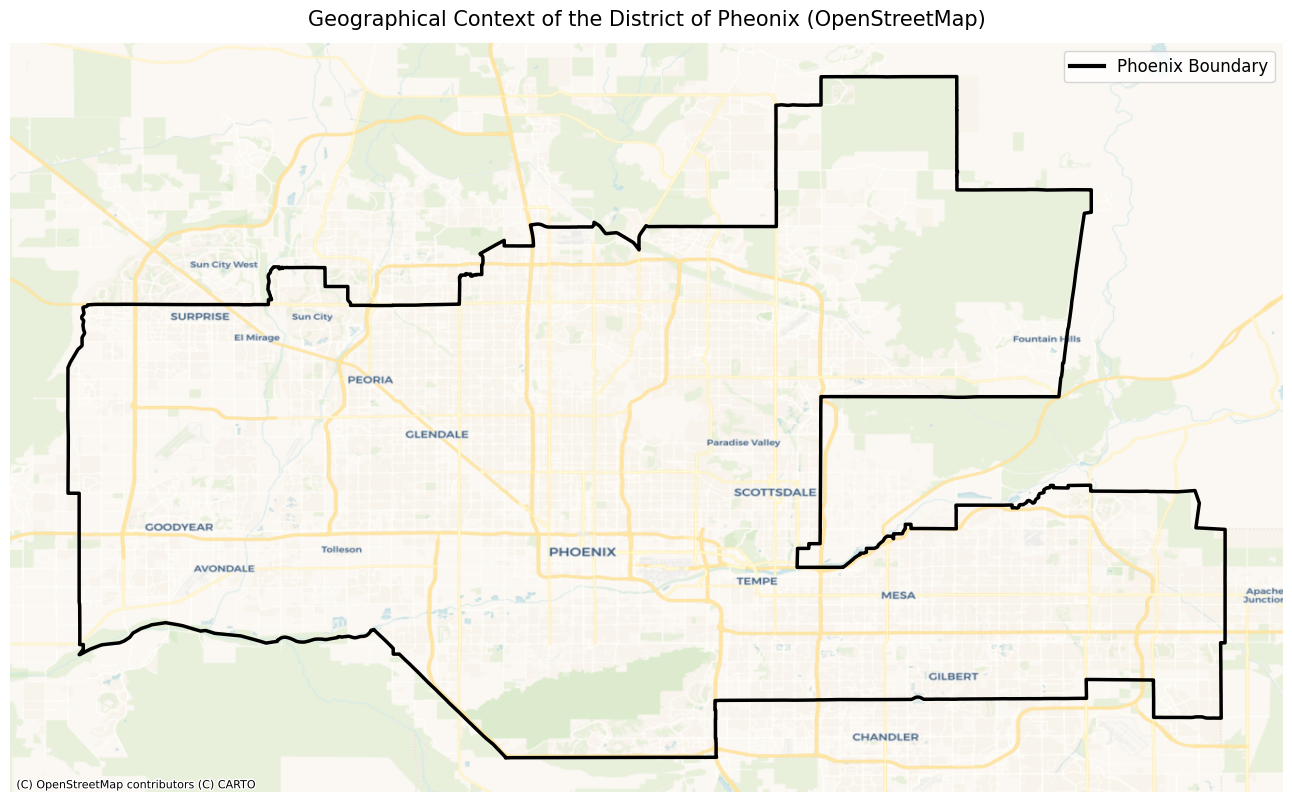

In [17]:
fig, ax = plt.subplots(figsize=(phoenix_2017_rast_mask.rio.width/60, 
                                phoenix_2017_rast_mask.rio.height/60))
ax.axis('off')

# Phoenix polygon
phoenix.boundary.plot(ax = ax, alpha = 1, color = 'black', linewidth = 2.5)

# Legend for phoenix polygon
ax.legend(handles = [Line2D([0], [0], color='black', lw=3)], 
          labels = ['Phoenix Boundary'], 
          loc = 'best', 
          fontsize = 'large')

# Openstreetmap basemap
cx.add_basemap(ax = ax, 
               crs = phoenix.crs, 
               source = cx.providers.CartoDB.Voyager)

ax.set_title('Geographical Context of the District of Pheonix (OpenStreetMap)', fontsize = 15, pad = 12)

plt.show()

In [18]:
# Calculate cell size for 2020
resolution_x_2020 = abs(phoenix_2020_rast_mask.x[1] - phoenix_2020_rast_mask.x[0])
resolution_y_2020 = abs(phoenix_2020_rast_mask.y[1] - phoenix_2020_rast_mask.y[0])

cell_size_2020 = resolution_x_2020 * resolution_y_2020

# Calculate cell sioze for 2017
resolution_x_2017 = abs(phoenix_2017_rast_mask.x[1] - phoenix_2017_rast_mask.x[0])
resolution_y_2017 = abs(phoenix_2017_rast_mask.y[1] - phoenix_2017_rast_mask.y[0])
 
cell_size_2017 = resolution_x_2017 * resolution_y_2017

# Total area of rasters
phoenix_2017_area = phoenix_2017_rast_mask.sum().item() * cell_size_2017
phoenix_2020_area = phoenix_2020_rast_mask.sum().item() * cell_size_2020

In [19]:
# Subset rasters for greater than 0.75 BII within phoenix
phoenix_2017_bii_75 = phoenix_2017_rast_mask.where((phoenix_2017_rast_mask >= 0.75) & (phoenix_2017_rast_mask != np.nan))
phoenix_2020_bii_75 = phoenix_2020_rast_mask.where((phoenix_2020_rast_mask >= 0.75) & (phoenix_2020_rast_mask != np.nan))

# Get area of subset
phoenix_2017_bii_75_area = phoenix_2017_bii_75.count() * cell_size_2017
phoenix_2020_bii_75_area = phoenix_2020_bii_75.count() * cell_size_2020

# Get percent of area that BII is greater than 0.75
phoenix_2017_pct_75 = (phoenix_2017_bii_75_area / phoenix_2017_area) * 100
phoenix_2020_pct_75 = (phoenix_2020_bii_75_area / phoenix_2020_area) * 100

In [20]:
[phoenix_2020_pct_75, phoenix_2017_pct_75]

[<xarray.DataArray ()>
 array(17.17745786)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(18.66693272)
 Coordinates:
     spatial_ref  int64 0]

In [21]:
# Create boolean rasters
phoenix_2017_bit = phoenix_2017_rast_mask >= 0.75
phoenix_2020_bit = phoenix_2020_rast_mask >= 0.75

# Make cell true if BII is greater than 0.75 in 2017 but not in 2020
phoenix_diff = (phoenix_2017_bit ^ phoenix_2020_bit)

# Set all true, false equal to 1, nan respectively
phoenix_diff = xr.where(phoenix_diff == True, 1, np.nan)

Text(0.5, 1.0, 'Area where BII loss exceeds 0.75 from 2017 to 2020 (Phoenix, AZ)')

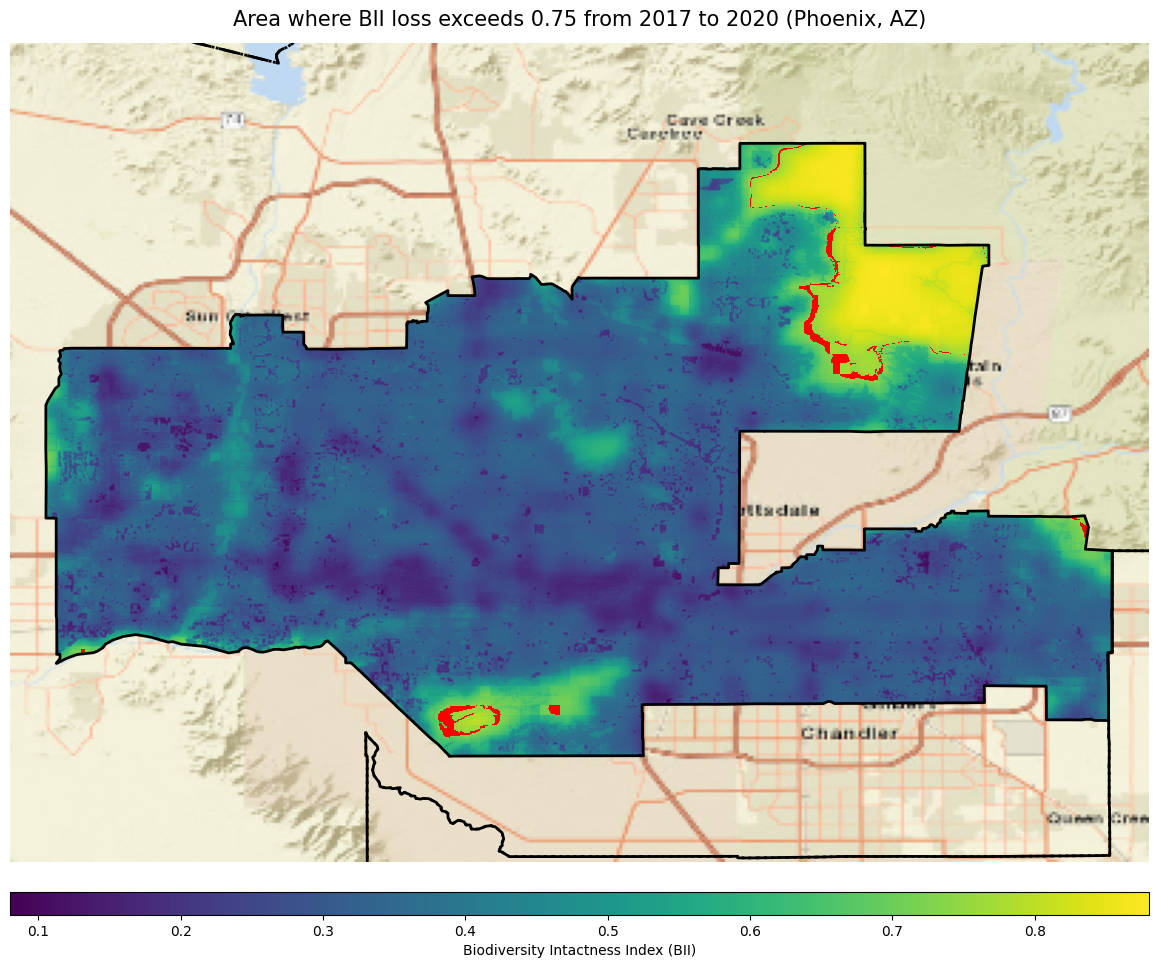

In [39]:
fig, ax = plt.subplots(figsize=(phoenix_2017_rast_mask.rio.width/67.5, 
                                phoenix_2017_rast_mask.rio.height/45))
ax.axis('off')

# Init mpl.toolkits basemap
bm = Basemap(projection='merc',
            resolution='c', llcrnrlon = -112.5, urcrnrlon = -111.55, llcrnrlat = 33.2, urcrnrlat = 33.9, epsg = 4269)

# County lines and basemap
bm.drawcounties(ax = ax, linewidth = 2, linestyle = '-.')
bm.arcgisimage(ax = ax, service = 'World_Street_Map')

# BII raster
bii = phoenix_2020_rast_mask.plot.imshow(ax=ax,
                                   cbar_kwargs = {'orientation': 'horizontal',
                                                  'pad': 0.03, 
                                                  'aspect': 50,
                                                  'label': 'Biodiversity Intactness Index (BII)'})

# Phoenix outline
phoenix.boundary.plot(ax = ax, alpha = 1, color = 'black', linewidth = 2)

# Areas of greater than 0.75 BII loss
phoenix_diff.plot.imshow(ax = ax,
                         colors = 'red',
                         levels = 2,
                         add_colorbar = False)

ax.set_title('Area where BII loss exceeds 0.75 from 2017 to 2020 (Phoenix, AZ)', fontsize = 15, pad = 12)

## BII Visualization Explanation

Analysis of BII in Phoenix, AZ as it changes from 2017 to 2020 suggests a thinning of biodiversity in the mountain ranges by the city. This occured within wilderness preserves close to the limits of the city and at the edges of BII hotspots suggesting a thinning from the sides of the ecosystem. 

A possible cause could be encroaching development and suburban sprawl, as Phoenix has expanded into many suburbs within the past 20 years. However, these preserves are also popular for recreation, and the desert exosystem is uniquely sensitive to disturbance, so it's possible human foot traffic may have played a role.